# MovieLens example
This example is based on the TFRS movie retrieval example you can find here: https://www.tensorflow.org/recommenders/examples/basic_retrieval.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Dict, Text

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tf_tabular.builder import InputBuilder
from tf_tabular.sequence_processor import SequenceProcessor

from examples.sequential.preprocessing import preprocess_dataset

In [3]:
# Ratings data.
ratings, ds_info = tfds.load("movielens/100k-ratings", split="train", with_info=True)
# Features of all the available movies.
movies, movie_info = tfds.load("movielens/100k-movies", split="train", with_info=True)

## Preprocessing

In [6]:
ratings_df = tfds.as_dataframe(ratings, ds_info)
movies_df = tfds.as_dataframe(movies, movie_info)

In [7]:
train_ds, val_ds, vocabs = preprocess_dataset(ratings_df, movies_df)

Unique users: 943
Train set size: (3672, 5)
Validation set size: (922, 5)


### Shuffle and split dataset

In [8]:
tf.random.set_seed(42)
train_ds = train_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

## Build model

In [9]:

class MovielensModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model

    def prepare_task(self, movies):
        id_candidates = (movies.ragged_batch(1024)
                         .prefetch(tf.data.AUTOTUNE)
                         .cache()
                         .map(lambda movie: (movie["movie_id"], self.movie_model({'target_id': movie['movie_id'],
                                                                                  'movie_genres': movie['movie_genres']}))))

        metrics = tfrs.metrics.FactorizedTopK(
            candidates=tfrs.layers.factorized_top_k.Streaming(k=100).index_from_dataset(id_candidates),
            ks=[1,5,100],
            name='factk'
        )
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True,
                                                       reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        task = tfrs.tasks.Retrieval(
            metrics=metrics,
            # num_hard_negatives=2,
            remove_accidental_hits=True,
            loss=loss
        )
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model({"user_history": features["user_history"],
                                           "history_ratings": features["history_ratings"]})
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.movie_model({"target_id": features["target_id"],
                                                      "movie_genres": features["movie_genres"]
                                                      })

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings,
                         candidate_ids=features["target_id"],
                         candidate_sampling_probability=features["sampling_prob"],
                        )


In [10]:


embedding_dims = {"target_id": 64,
                  "movie_genres": 32}

def build_movie_model():
    input_builder = InputBuilder()
    input_builder.add_inputs_list(categoricals=["target_id", "movie_genres"],
                                  vocabs=vocabs,
                                  multi_hots=["movie_genres"],
                                  embedding_dims=embedding_dims)
    inputs, output = input_builder.build_input_layers()
    x = Dense(32, activation=None)(output)
    return Model(inputs=inputs, outputs=x)

movie_model = build_movie_model()

In [11]:
embedding_dims = {"user_history": 64}

def build_user_model():
    input_builder = InputBuilder(sequence_processor=SequenceProcessor(key_dim=64))
    input_builder.add_inputs_list(categoricals=["user_history"],
                                  numericals=["history_ratings"],
                                  vocabs=vocabs,
                                  sequentials=["user_history", "history_ratings"],
                                  embedding_dims=embedding_dims)
    inputs, output = input_builder.build_input_layers()
    x = Dense(32, activation=None)(output)
    return Model(inputs=inputs, outputs=x)

user_model = build_user_model()

No normalization parameters found for history_ratings. Not normalizing this column


In [12]:
model = MovielensModel(user_model, movie_model)
model.prepare_task(movies)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003))


Cache the training and test data

In [13]:
cached_train = train_ds.shuffle(100_000).ragged_batch(128).cache()
cached_val = val_ds.ragged_batch(128).cache()


In [14]:
model.fit(cached_train, epochs=10)

Epoch 1/10
29/29 [==============================] - 31s 976ms/step - factk/top_1_categorical_accuracy: 0.0035 - factk/top_5_categorical_accuracy: 0.0193 - factk/top_100_categorical_accuracy: 0.2399 - loss: 5.0386 - regularization_loss: 0.0000e+00 - total_loss: 5.0386
Epoch 2/10
29/29 [==============================] - 29s 997ms/step - factk/top_1_categorical_accuracy: 0.0065 - factk/top_5_categorical_accuracy: 0.0275 - factk/top_100_categorical_accuracy: 0.3096 - loss: 4.8373 - regularization_loss: 0.0000e+00 - total_loss: 4.8373
Epoch 3/10
29/29 [==============================] - 29s 994ms/step - factk/top_1_categorical_accuracy: 0.0074 - factk/top_5_categorical_accuracy: 0.0308 - factk/top_100_categorical_accuracy: 0.3314 - loss: 4.7736 - regularization_loss: 0.0000e+00 - total_loss: 4.7736
Epoch 4/10
29/29 [==============================] - 30s 1s/step - factk/top_1_categorical_accuracy: 0.0068 - factk/top_5_categorical_accuracy: 0.0338 - factk/top_100_categorical_accuracy: 0.3608 -

### Evaluation

In [15]:
model.evaluate(cached_val, return_dict=True)

8/8 [==============================] - 3s 300ms/step - factk/top_1_categorical_accuracy: 0.0076 - factk/top_5_categorical_accuracy: 0.0325 - factk/top_100_categorical_accuracy: 0.3200 - loss: 5.0689 - regularization_loss: 0.0000e+00 - total_loss: 5.0689


{'factk/top_1_categorical_accuracy': 0.0075921909883618355,
 'factk/top_5_categorical_accuracy': 0.03253795951604843,
 'factk/top_100_categorical_accuracy': 0.31995663046836853,
 'loss': 3.975198984146118,
 'regularization_loss': 0,
 'total_loss': 3.975198984146118}

## Visualizing the user model part:

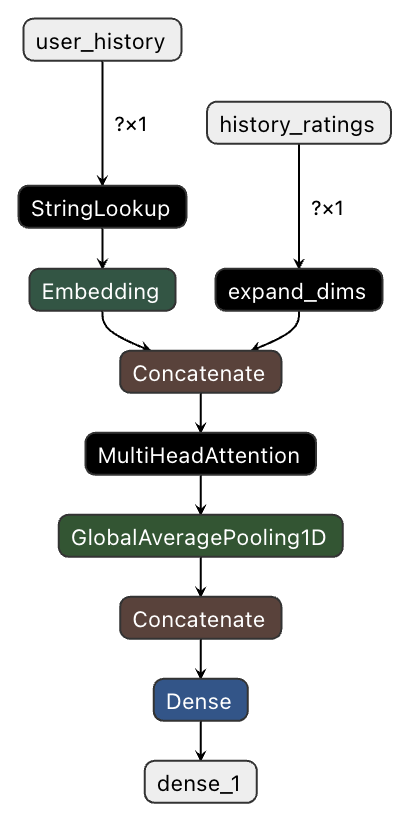

In [27]:
from IPython.display import Image
Image("user_model.png", width=240)